Districtwise in/out numbers provided by Ncell seems to be qutie dirty.  
  
**Problems discovered**  
1. Data for Kathmandu, Bhaktapur and Lalitpur are aggregated as Kathmandu Valley
2. Data for Nawalparasi East and Nawalparasi West are aggregated as Nawalparasi
3. Data for Rukim East and Rukum West are aggregated as Rukum
4. Districts Dhanusa (Dhanusha), Kavrepalanchok (Kabhrepalanchok), Kapilvastu (Kapilbastu), Makwanpur (Makawanpur) are spelt wrong
5. In/out data for districts Dolpa, Humla and Mustang are missing
6. 17 datapoints have null district names
7. The data are from **2020/05/31** to **2020/06/16**. We need data from **2020/03/29** to **2020/05/12**

**Proposed Solution**  

1. Aggregated data will be segregated using population ratio of the respective districts.  
2. Kathmandu valley aggregation will be kept intact because of massive mobility within the three districts
3. Spellings will be corrected using our other datasets as reference.  
4. In/out data for the three missing districts will be approximated using their population data and data from neighboring districts
5. Datapoints with missing district names will be dropped
6. **Extrapolate data for earlier dates? :-\**

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
# Dataset with correctly named districts.
# This will be used as reference to correct Ncell's misspelt words

infected_df = pd.read_csv('infected.csv')
ref_districts = sorted(infected_df['District'])
len(ref_districts)

77

In [3]:
infected_df.head()

,Unnamed: 0,District,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,...,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12
0,0,Panchthar,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Ilam,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,Jhapa,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
3,3,Morang,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,Sunsari,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Let's proceed with combining the three districts in Kathmndu valley
# for every other datasets we have

valley_combined = pd.DataFrame(infected_df[
    (infected_df['District'] == 'Kathmandu') |
    (infected_df['District'] == 'Bhaktapur') |
    (infected_df['District'] == 'Lalitpur')
].sum()).T

valley_combined.iloc[0]['District'] = 'Kathmandu valley'
valley_combined

,Unnamed: 0,District,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,...,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12
0,116,Kathmandu valley,3,3,3,3,3,3,3,3,...,5,5,5,5,5,5,5,5,5,8


In [5]:
# append valley's data and remove individual districts from the dataset

infected_df = infected_df.append(valley_combined)
infected_df = infected_df[~infected_df['District'].isin(['Kathmandu', 'Bhaktapur', 'Lalitpur'])]
infected_df.shape

(75, 47)

In [6]:
# redefine reference districts

ref_districts = infected_df['District']
len(ref_districts)

75

Looks good.

In [7]:
# Loading mobility data provided by Ncell

ncell_df = pd.read_csv('districtwise_in_out.csv')
ncell_df['district1'] = ncell_df['district1'].str.capitalize()
ncell_df.head()

,dayid1,district1,outgoing_cnt,incoming_cnt
0,20200531,Sankhuwasabha,4048,4050
1,20200531,Dhading,6203,6254
2,20200531,Saptari,4843,5290
3,20200531,Dailekh,741,753
4,20200531,Ilam,7144,7251


In [8]:
# Quick sanity check

ncell_df.dropna(axis=0, inplace=True)

def display_data_status():
    print('Unique districts count in Ncell\'s data:', len(ncell_df['district1'].unique()))
    print('In Ncell\'s, but not in ours:', set(ncell_df['district1'].unique()) - set(ref_districts))
    print('In our\'s but not in Ncell\'s:', set(ref_districts) - set(ncell_df['district1'].unique()))
    
display_data_status()

Unique districts count in Ncell's data: 70
In Ncell's, but not in ours: {'Makwanpur', 'Nawalparasi', 'Kavrepalanchok', 'Rukum', 'Dhanusa', 'Kapilvastu'}
In our's but not in Ncell's: {'Kapilbastu', 'Nawalparasi East', 'Dhanusha', 'Humla', 'Makawanpur', 'Kabhrepalanchok', 'Rukum East', 'Nawalparasi West', 'Rukum West', 'Mustang', 'Dolpa'}


Out of 70 districts from Ncell's data, **Nawalparasi** will be segregated into **Nawalparasi East** and **Nawalparasi West**. New district count will be 71.
**Rukum** will be segregated into **Rukum East** and **Rukum West**. New district count will be 72.
Data for districts **Dolpa**, **Humla** and **Mustang** will be approximated. New district count will be 75.  
**Kathmandu valley** aggregation will be left intact.
  
*Everything else seems fine.*

In [9]:
# Let's create a dictionary that pairs incorrectly spelt districts with 
# their correct spellings. We will use this dict to correct spellings

incorrect_correct_mapping = {
    'Dhanusa': 'Dhanusha',
    'Makwanpur': 'Makawanpur',
    'Kavrepalanchok': 'Kabhrepalanchok',
    'Kapilvastu': 'Kapilbastu'
}

# Let's proceed to make these corrections

ncell_df.replace(
    incorrect_correct_mapping.keys(), 
    incorrect_correct_mapping.values(), 
    inplace=True
)
        
display_data_status()

Unique districts count in Ncell's data: 70
In Ncell's, but not in ours: {'Nawalparasi', 'Rukum'}
In our's but not in Ncell's: {'Nawalparasi East', 'Humla', 'Rukum East', 'Nawalparasi West', 'Rukum West', 'Mustang', 'Dolpa'}


So far, so good.  
Next up, we will need some population data to segregate the aggregated districts.

In [10]:
# Loading population data

pop_df = pd.read_csv('pop.csv')
pop_df.drop('Unnamed: 0', inplace=True, axis=1)
pop_df.head()

,DIST_EN,population_2020
0,Achham,209318
1,Arghakhanchi,139054
2,Baglung,198447
3,Baitadi,197067
4,Bajhang,165950


In [11]:
# Time to aggregate the valley districts in this dataset as well

valley_pop = pd.DataFrame(pop_df[
    (pop_df['DIST_EN'] == 'Kathmandu') |
    (pop_df['DIST_EN'] == 'Bhaktapur') |
    (pop_df['DIST_EN'] == 'Lalitpur')
].sum()).T

valley_pop.iloc[0]['DIST_EN'] = 'Kathmandu valley'
valley_pop

pop_df = pop_df.append(valley_pop)
pop_df = pop_df[~pop_df['DIST_EN'].isin(['Kathmandu', 'Bhaktapur', 'Lalitpur'])]
pop_df.shape

(75, 2)

In [12]:
# pop_ktm = pop_df[pop_df['DIST_EN'] == 'Kathmandu']['population_2020'].values[0]
# pop_bha = pop_df[pop_df['DIST_EN'] == 'Bhaktapur']['population_2020'].values[0]
# pop_ltp = pop_df[pop_df['DIST_EN'] == 'Lalitpur']['population_2020'].values[0]

pop_rue = pop_df[pop_df['DIST_EN'] == 'Rukum East']['population_2020'].values[0]
pop_ruw = pop_df[pop_df['DIST_EN'] == 'Rukum West']['population_2020'].values[0]

pop_npe = pop_df[pop_df['DIST_EN'] == 'Nawalparasi East']['population_2020'].values[0]
pop_npw = pop_df[pop_df['DIST_EN'] == 'Nawalparasi West']['population_2020'].values[0]

# ktm_valley = ncell_df[ncell_df['district1'] == 'Kathmandu valley'].copy()
rukum      = ncell_df[ncell_df['district1'] == 'Rukum']           .copy()
nparasi    = ncell_df[ncell_df['district1'] == 'Nawalparasi']     .copy()

print('Population Info')
print('-'*35)

# print('Kathmandu:\t\t', pop_ktm)
# print('Bhaktapur:\t\t', pop_bha)
# print('Lalitpur:\t\t', pop_ltp)
print('\nRukum East:\t\t', pop_rue)
print('Rukum West:\t\t', pop_ruw)
print('\nNawalparasi East:\t', pop_npe)
print('Nawalparasi West:\t', pop_npw)

Population Info
-----------------------------------

Rukum East:		 49814
Rukum West:		 120881

Nawalparasi East:	 261328
Nawalparasi West:	 284886


In [13]:
rue_in_out = pd.DataFrame(columns = rukum.columns)
ruw_in_out = pd.DataFrame(columns = rukum.columns)

pop_rukum_total = pop_rue + pop_ruw

rue_in_out['dayid1'] = rukum['dayid1']
rue_in_out['district1'] = ['Rukum East'] * len(rukum)
rue_in_out['outgoing_cnt'] = (rukum['outgoing_cnt'] * (pop_rue / pop_rukum_total)).round()
rue_in_out['incoming_cnt'] = (rukum['incoming_cnt'] * (pop_rue / pop_rukum_total)).round()

ruw_in_out['dayid1'] = rukum['dayid1']
ruw_in_out['district1'] = ['Rukum West'] * len(rukum)
ruw_in_out['outgoing_cnt'] = (rukum['outgoing_cnt'] * (pop_ruw / pop_rukum_total)).round()
ruw_in_out['incoming_cnt'] = (rukum['incoming_cnt'] * (pop_ruw / pop_rukum_total)).round()

In [14]:
(ruw_in_out['incoming_cnt'] + rue_in_out['incoming_cnt']).sum()

31037.0

In [15]:
rukum['incoming_cnt'].sum()

31037

In [16]:
npe_in_out = pd.DataFrame(columns = nparasi.columns)
npw_in_out = pd.DataFrame(columns = nparasi.columns)

pop_nparasi_total = pop_npe + pop_npw

npe_in_out['dayid1'] = nparasi['dayid1']
npe_in_out['district1'] = ['Nawalparasi East'] * len(nparasi)
npe_in_out['outgoing_cnt'] = (nparasi['outgoing_cnt'] * (pop_npe / pop_nparasi_total)).round()
npe_in_out['incoming_cnt'] = (nparasi['incoming_cnt'] * (pop_npe / pop_nparasi_total)).round()

npw_in_out['dayid1'] = nparasi['dayid1']
npw_in_out['district1'] = ['Nawalparasi West'] * len(nparasi)
npw_in_out['outgoing_cnt'] = (nparasi['outgoing_cnt'] * (pop_npw / pop_nparasi_total)).round()
npw_in_out['incoming_cnt'] = (nparasi['incoming_cnt'] * (pop_npw / pop_nparasi_total)).round()

#### Sanity Checks

In [17]:
rue_in_out.join(ruw_in_out, how='inner', lsuffix='_rue', rsuffix='_ruw')

,dayid1_rue,district1_rue,outgoing_cnt_rue,incoming_cnt_rue,dayid1_ruw,district1_ruw,outgoing_cnt_ruw,incoming_cnt_ruw
18,20200531,Rukum East,587.0,422.0,20200531,Rukum West,1425.0,1024.0
136,20200601,Rukum East,534.0,513.0,20200601,Rukum West,1295.0,1245.0
172,20200602,Rukum East,500.0,534.0,20200602,Rukum West,1213.0,1296.0
230,20200603,Rukum East,522.0,525.0,20200603,Rukum West,1266.0,1274.0
339,20200604,Rukum East,516.0,555.0,20200604,Rukum West,1253.0,1346.0
359,20200605,Rukum East,570.0,503.0,20200605,Rukum West,1384.0,1219.0
435,20200606,Rukum East,479.0,496.0,20200606,Rukum West,1164.0,1203.0
540,20200607,Rukum East,498.0,510.0,20200607,Rukum West,1210.0,1239.0
563,20200608,Rukum East,538.0,561.0,20200608,Rukum West,1307.0,1360.0
691,20200609,Rukum East,522.0,550.0,20200609,Rukum West,1265.0,1334.0


In [18]:
npe_in_out.join(npw_in_out, how='inner', lsuffix='_npe', rsuffix='_npw')

,dayid1_npe,district1_npe,outgoing_cnt_npe,incoming_cnt_npe,dayid1_npw,district1_npw,outgoing_cnt_npw,incoming_cnt_npw
46,20200531,Nawalparasi East,2971.0,2771.0,20200531,Nawalparasi West,3238.0,3021.0
128,20200601,Nawalparasi East,3022.0,3012.0,20200601,Nawalparasi West,3294.0,3283.0
187,20200602,Nawalparasi East,3040.0,3125.0,20200602,Nawalparasi West,3314.0,3406.0
228,20200603,Nawalparasi East,3146.0,3123.0,20200603,Nawalparasi West,3430.0,3405.0
330,20200604,Nawalparasi East,3249.0,3170.0,20200604,Nawalparasi West,3541.0,3456.0
356,20200605,Nawalparasi East,3103.0,3171.0,20200605,Nawalparasi West,3382.0,3457.0
467,20200606,Nawalparasi East,2888.0,3049.0,20200606,Nawalparasi West,3149.0,3323.0
527,20200607,Nawalparasi East,3185.0,3024.0,20200607,Nawalparasi West,3473.0,3297.0
621,20200608,Nawalparasi East,3249.0,3267.0,20200608,Nawalparasi West,3542.0,3561.0
677,20200609,Nawalparasi East,3319.0,3234.0,20200609,Nawalparasi West,3619.0,3526.0


Segregation for districts **Rukum** and **Nawalparasi** looks quite convincing.

I have a feeling that the missing districts: **Dolpa**, **Humla** and **Mustang** had simply no one crossing the border.  
Let's check which districts have very little number of people moving around.

In [19]:
ncell_df[ncell_df['outgoing_cnt'] < 20]['district1'].unique()

array(['Jumla', 'Manang', 'Mugu'], dtype=object)

In [20]:
ncell_df[ncell_df['incoming_cnt'] < 20]['district1'].unique()

array(['Jumla', 'Manang', 'Mugu', 'Kalikot'], dtype=object)

My suspicions might be correct after all.  
Districts with minimal number of people crossing the border are neighboring districts of the missing ones.  
Filling those missing districts with zero number of people moving around might not be a bad idea at all! Let's do that.

In [21]:
dolpa_in_out = pd.DataFrame(columns = rukum.columns)
humla_in_out = pd.DataFrame(columns = rukum.columns)
mustang_in_out = pd.DataFrame(columns = rukum.columns)

dolpa_in_out['dayid1'] = rukum['dayid1']  # using ktm_valley works because all districts have same range of dates
dolpa_in_out['district1'] = ['Dolpa'] * len(rukum)
dolpa_in_out['outgoing_cnt'] = 0
dolpa_in_out['incoming_cnt'] = 0

humla_in_out['dayid1'] = rukum['dayid1']
humla_in_out['district1'] = ['Humla'] * len(rukum)
humla_in_out['outgoing_cnt'] = 0
humla_in_out['incoming_cnt'] = 0

mustang_in_out['dayid1'] = rukum['dayid1']
mustang_in_out['district1'] = ['Mustang'] * len(rukum)
mustang_in_out['outgoing_cnt'] = 0
mustang_in_out['incoming_cnt'] = 0

In [22]:
dolpa_in_out

,dayid1,district1,outgoing_cnt,incoming_cnt
18,20200531,Dolpa,0,0
136,20200601,Dolpa,0,0
172,20200602,Dolpa,0,0
230,20200603,Dolpa,0,0
339,20200604,Dolpa,0,0
359,20200605,Dolpa,0,0
435,20200606,Dolpa,0,0
540,20200607,Dolpa,0,0
563,20200608,Dolpa,0,0
691,20200609,Dolpa,0,0


In [23]:
full_df = ncell_df.copy()
full_df = full_df.append(rue_in_out).append(ruw_in_out).append(npe_in_out).append(
    npw_in_out
).append(humla_in_out).append(dolpa_in_out).append(mustang_in_out)

full_df = full_df[~full_df['district1'].isin(['Rukum', 'Nawalparasi'])]

In [24]:
len(full_df['district1'].unique())

75

In [25]:
full_df.isnull().sum()

dayid1          0
district1       0
outgoing_cnt    0
incoming_cnt    0
dtype: int64

**NICE!!**  
now,  

### Extrapolation :(

In [26]:
full_df['dayid1'] = pd.to_datetime(full_df['dayid1'], format='%Y%m%d')
full_df.head()

,dayid1,district1,outgoing_cnt,incoming_cnt
0,2020-05-31,Sankhuwasabha,4048.0,4050.0
1,2020-05-31,Dhading,6203.0,6254.0
2,2020-05-31,Saptari,4843.0,5290.0
3,2020-05-31,Dailekh,741.0,753.0
4,2020-05-31,Ilam,7144.0,7251.0


Let's see some graphs!!

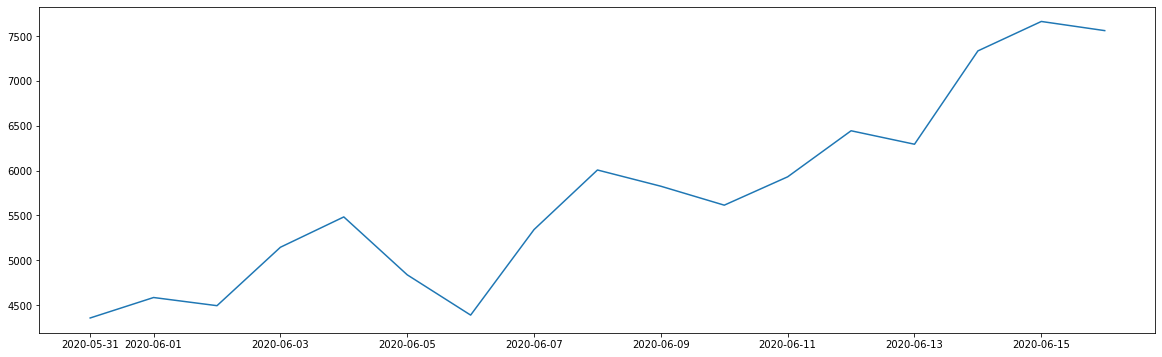

In [27]:
plt.figure(figsize=(20,6))
_, labels = plt.xticks()
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Kathmandu valley'], label='Kathmandu valley')

In [28]:
full_df[full_df['district1'] == 'Kathmandu valley'].mean()

outgoing_cnt    5724.352941
incoming_cnt    5252.882353
dtype: float64

In [29]:
full_df[full_df['district1'] == 'Kathmandu valley'].std()

outgoing_cnt    1074.663549
incoming_cnt     493.328223
dtype: float64

#### Outgoing counts for Province 1

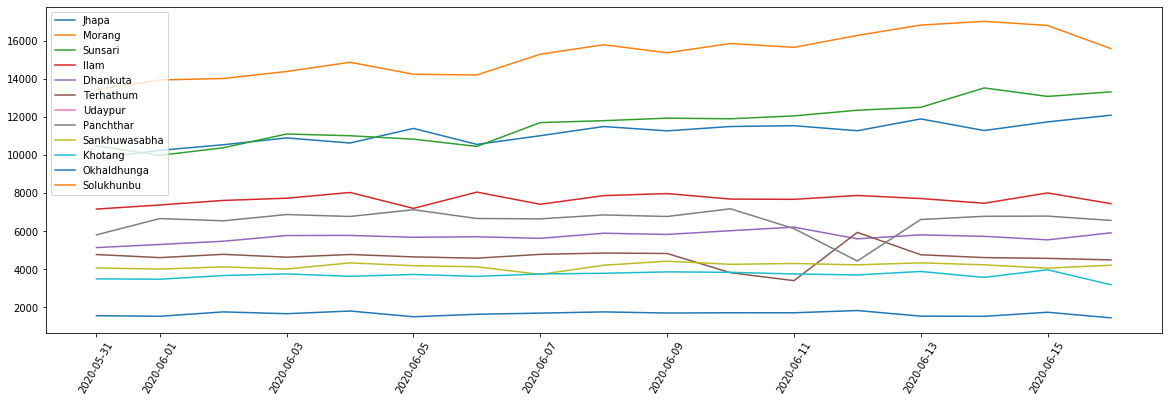

In [30]:
plt.figure(figsize=(20,6))
_, labels = plt.xticks()
plt.setp(labels, rotation=60)
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Jhapa'], label='Jhapa')
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Morang'], label='Morang')
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Sunsari'], label='Sunsari')
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Ilam'], label='Ilam')
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Dhankuta'], label='Dhankuta')
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Terhathum'], label='Terhathum')
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Udaypur'], label='Udaypur')
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Panchthar'], label='Panchthar')
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Sankhuwasabha'], label='Sankhuwasabha')
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Khotang'], label='Khotang')
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Okhaldhunga'], label='Okhaldhunga')
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Solukhunbu'], label='Solukhunbu')
plt.legend(loc='upper left')

#### Incoming counts for Province 1

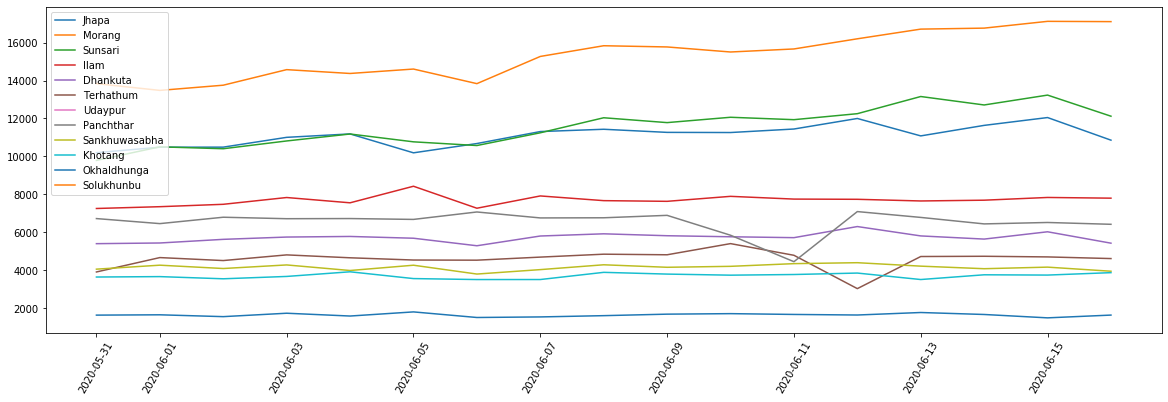

In [31]:
plt.figure(figsize=(20,6))
_, labels = plt.xticks()
plt.setp(labels, rotation=60)
plt.plot('dayid1', 'incoming_cnt', data=full_df[full_df['district1'] == 'Jhapa'], label='Jhapa')
plt.plot('dayid1', 'incoming_cnt', data=full_df[full_df['district1'] == 'Morang'], label='Morang')
plt.plot('dayid1', 'incoming_cnt', data=full_df[full_df['district1'] == 'Sunsari'], label='Sunsari')
plt.plot('dayid1', 'incoming_cnt', data=full_df[full_df['district1'] == 'Ilam'], label='Ilam')
plt.plot('dayid1', 'incoming_cnt', data=full_df[full_df['district1'] == 'Dhankuta'], label='Dhankuta')
plt.plot('dayid1', 'incoming_cnt', data=full_df[full_df['district1'] == 'Terhathum'], label='Terhathum')
plt.plot('dayid1', 'incoming_cnt', data=full_df[full_df['district1'] == 'Udaypur'], label='Udaypur')
plt.plot('dayid1', 'incoming_cnt', data=full_df[full_df['district1'] == 'Panchthar'], label='Panchthar')
plt.plot('dayid1', 'incoming_cnt', data=full_df[full_df['district1'] == 'Sankhuwasabha'], label='Sankhuwasabha')
plt.plot('dayid1', 'incoming_cnt', data=full_df[full_df['district1'] == 'Khotang'], label='Khotang')
plt.plot('dayid1', 'incoming_cnt', data=full_df[full_df['district1'] == 'Okhaldhunga'], label='Okhaldhunga')
plt.plot('dayid1', 'incoming_cnt', data=full_df[full_df['district1'] == 'Solukhunbu'], label='Solukhunbu')
plt.legend(loc='upper left')

#### Outgoing counts for Province 2

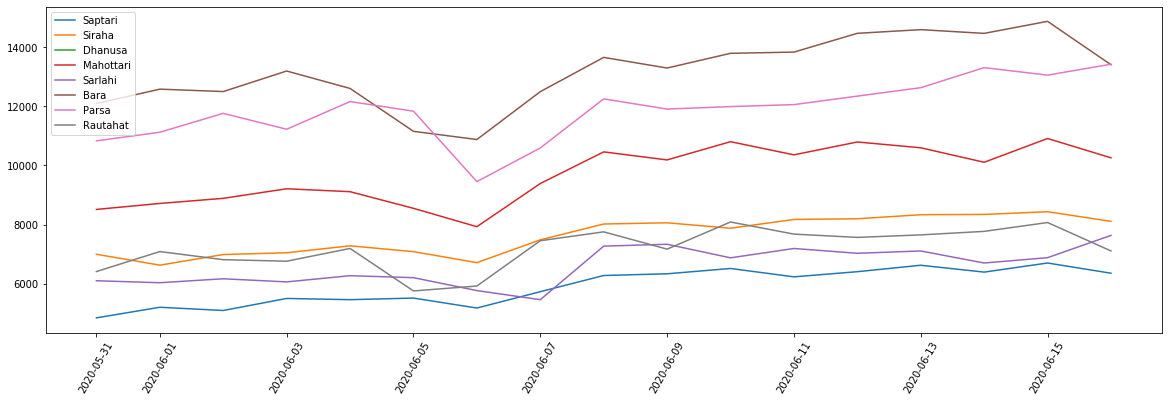

In [32]:
plt.figure(figsize=(20,6))
_, labels = plt.xticks()
plt.setp(labels, rotation=60)
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Saptari'], label='Saptari')
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Siraha'], label='Siraha')
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Dhanusa'], label='Dhanusa')
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Mahottari'], label='Mahottari')
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Sarlahi'], label='Sarlahi')
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Bara'], label='Bara')
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Parsa'], label='Parsa')
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Rautahat'], label='Rautahat')
plt.legend(loc='upper left')

#### Incoming counts for Province 2

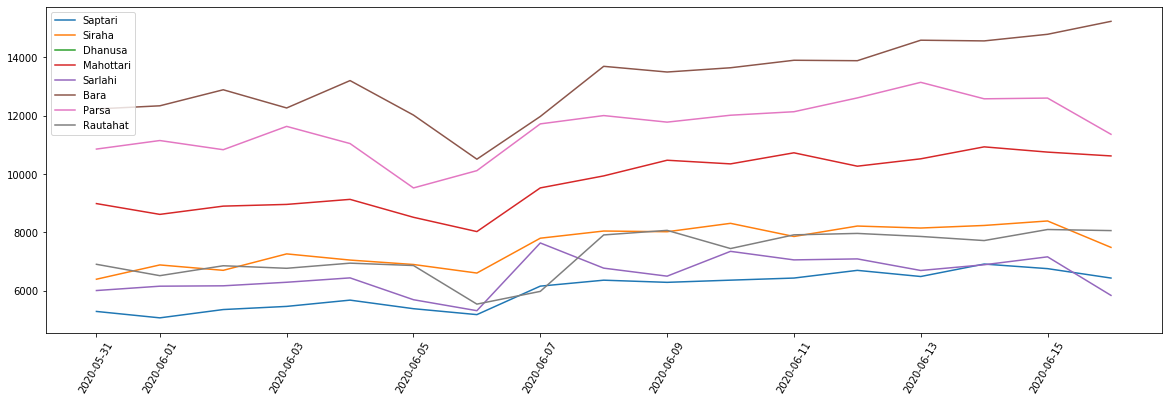

In [33]:
plt.figure(figsize=(20,6))
_, labels = plt.xticks()
plt.setp(labels, rotation=60)
plt.plot('dayid1', 'incoming_cnt', data=full_df[full_df['district1'] == 'Saptari'], label='Saptari')
plt.plot('dayid1', 'incoming_cnt', data=full_df[full_df['district1'] == 'Siraha'], label='Siraha')
plt.plot('dayid1', 'incoming_cnt', data=full_df[full_df['district1'] == 'Dhanusa'], label='Dhanusa')
plt.plot('dayid1', 'incoming_cnt', data=full_df[full_df['district1'] == 'Mahottari'], label='Mahottari')
plt.plot('dayid1', 'incoming_cnt', data=full_df[full_df['district1'] == 'Sarlahi'], label='Sarlahi')
plt.plot('dayid1', 'incoming_cnt', data=full_df[full_df['district1'] == 'Bara'], label='Bara')
plt.plot('dayid1', 'incoming_cnt', data=full_df[full_df['district1'] == 'Parsa'], label='Parsa')
plt.plot('dayid1', 'incoming_cnt', data=full_df[full_df['district1'] == 'Rautahat'], label='Rautahat')
plt.legend(loc='upper left')

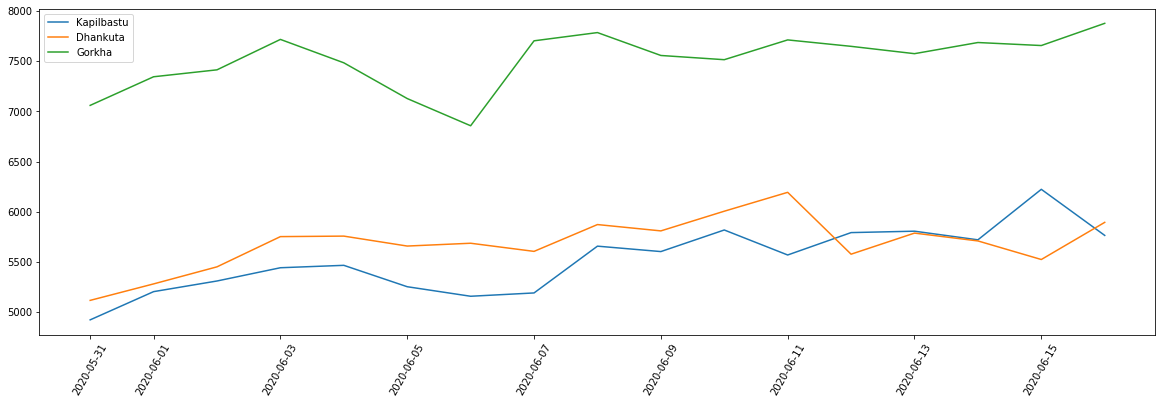

In [34]:
plt.figure(figsize=(20,6))
_, labels = plt.xticks()
plt.setp(labels, rotation=60)
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Kapilbastu'], label='Kapilbastu')
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Dhankuta'], label='Dhankuta')
plt.plot('dayid1', 'outgoing_cnt', data=full_df[full_df['district1'] == 'Gorkha'], label='Gorkha')
plt.legend(loc='upper left')

I really don't know what to make of this...   
Movement doesn't seem to have any trend.   
How do I approximate movement of people from two months earlier??  
  
I think if I just loop the movements backwards, it could be a half-decent estimate.   
These data are from during the lockdown period and it would be safe to assume (?) similar movements because the earlier time is also during the lockdown period. However, there are some spikes on 6th of June which will be repeated and might cause our model to learn something that's not true.  
  
Another idea is to create a probability density function for each districts and take random samples from that distribution. This method would preserve the distribution bounds, but will loose information like those spikes that can be seen on 6th of June...   
  
I'll go with the probability density method.

In [35]:
# Let's do a quick test

district = 'Kathmandu valley'

kde = stats.gaussian_kde(full_df[full_df['district1'] == district]['outgoing_cnt'])

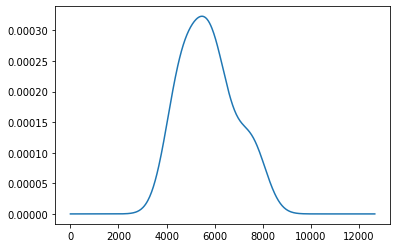

In [36]:
xmin = full_df[full_df['district1'] == district]['outgoing_cnt'].min()
xmax = full_df[full_df['district1'] == district]['outgoing_cnt'].max()

x = np.linspace(0, xmax+5000, 500)
plt.plot(x, kde(x))

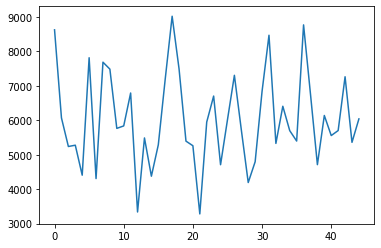

In [37]:
test = kde.resample(45)[0] # we need to fill mobility data for 45 days
plt.plot(test)

In [38]:
kde_test = stats.gaussian_kde(test)

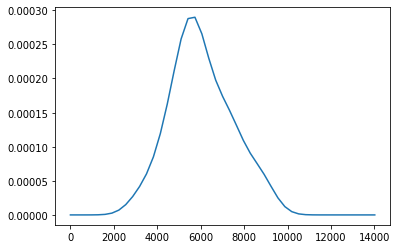

In [39]:
test_xmin = np.array(test).min()
test_xmax = np.array(test).max()
x_test = np.linspace(0, test_xmax+5000, 45)

plt.plot(x_test, kde_test(x_test))

This looks much like the original distribution.   
Successfully created random points based on the original distribution.  
However, the data looks horribly jumpy!  

Each day has mobility difference of thousands!

Next up, I'll try something to make it smoother.  
The idea is to generate lots of resamples and take aggregate. Hopefully, the generated data will then look much nicer.  
But we will certainly see a massive drop in standard deviations.

In [40]:
smooth_rand_data = []
last_items = []
for _ in range(1000):
    rand_data = kde.resample(45)[0]
    smooth_rand_data.append(rand_data)
    
smooth_rand_data = np.array(smooth_rand_data)
smooth_rand_data = np.average(smooth_rand_data, axis=0).reshape((1,45))[0]

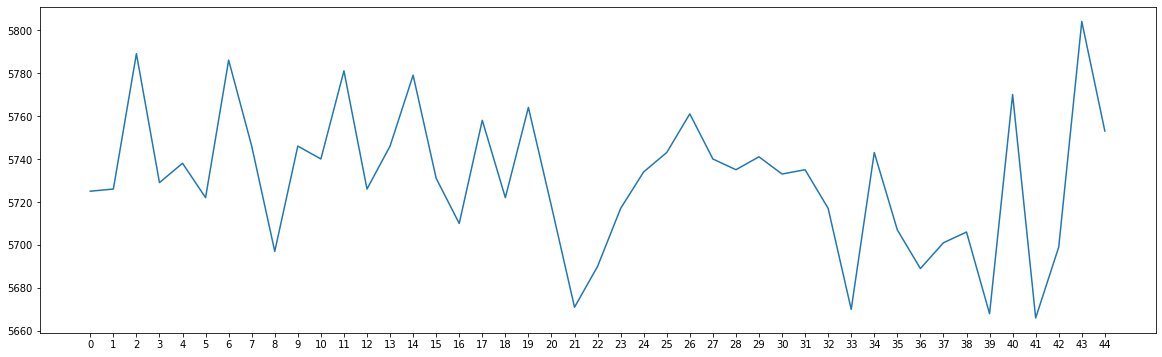

In [41]:
smooth_rand_data = smooth_rand_data.round()
plt.figure(figsize=(20,6))
plt.xticks(np.arange(0, 45, 1))
plt.plot(smooth_rand_data)

In [42]:
smooth_rand_data.mean()

5730.488888888889

In [43]:
smooth_rand_data.std()

32.334104610885

Standard deviation has decreased significantly which is to be expected after all the 'smoothing' stuff we tried earlier.

In [44]:
full_df.sort_values(by='district1')

,dayid1,district1,outgoing_cnt,incoming_cnt
962,2020-06-13,Achham,906.0,755.0
17,2020-05-31,Achham,890.0,706.0
549,2020-06-07,Achham,826.0,791.0
474,2020-06-06,Achham,873.0,693.0
1181,2020-06-16,Achham,849.0,764.0
...,...,...,...,...
39,2020-05-31,Udayapur,4766.0,4755.0
484,2020-06-06,Udayapur,4824.0,4965.0
938,2020-06-13,Udayapur,5510.0,5332.0
791,2020-06-11,Udayapur,5474.0,5276.0


In [45]:
# Let's do this stuff for all districts

synthetic_full_df = pd.DataFrame(columns = full_df.columns)
dist_details = {'district1': [], 'outgoing_cnt': [], 'incoming_cnt': []}

for dist in ref_districts:
    dist_details['district1'] += [dist]*45
    
    if dist in ['Dolpa', 'Humla', 'Mustang']:
        # These districts have 0 movements
        # the script would crash while trying
        # to get the gaussian_kde becuase they
        # are singular matrices.
        # we will manually add them
        
        dist_details['outgoing_cnt'] += [1] * 45 # list(np.random.normal(7, 1, 45).astype('int32'))
        dist_details['incoming_cnt'] += [1] * 45 # list(np.random.normal(7, 1, 45).astype('int32'))
        
        # you might have noticed, we didn't fill these with zeros
        # That's because I'm very scared of divide-by-zero errors
        
        continue  # onwards! to another district.
    
    for direction in ['outgoing_cnt', 'incoming_cnt']:
        kde = stats.gaussian_kde(full_df[full_df['district1'] == dist][direction])
        
        smooth_rand_data = []
        
        for _ in range(1000):
            rand_data = kde.resample(45)[0]
            smooth_rand_data.append(rand_data)

        smooth_rand_data = np.array(smooth_rand_data)
        smooth_rand_data = np.average(smooth_rand_data, axis=0).reshape((1,45))[0].round()
        
        if direction == 'outgoing_cnt':
            dist_details['outgoing_cnt'] += list(smooth_rand_data)
        else:
            dist_details['incoming_cnt'] += list(smooth_rand_data)

synthetic_full_df = synthetic_full_df.append(pd.DataFrame(dist_details, columns = full_df.columns))

In [46]:
synthetic_full_df

,dayid1,district1,outgoing_cnt,incoming_cnt
0,NaN,Panchthar,6578.0,6556.0
1,NaN,Panchthar,6500.0,6550.0
2,NaN,Panchthar,6542.0,6525.0
3,NaN,Panchthar,6542.0,6555.0
4,NaN,Panchthar,6500.0,6566.0
...,...,...,...,...
3370,NaN,Kathmandu valley,5604.0,5253.0
3371,NaN,Kathmandu valley,5740.0,5250.0
3372,NaN,Kathmandu valley,5732.0,5263.0
3373,NaN,Kathmandu valley,5749.0,5223.0


Great! Now let's fill the `dayid1` column

In [47]:
from datetime import date, timedelta

len([date.date().strftime('%Y-%m-%d') for date in list(pd.date_range(
    pd.to_datetime('2020-03-29').date(),
    pd.to_datetime('2020-05-13').date() - timedelta(days=1),
    freq='d'
))] * 75) # does the length match with dataframe's length?

3375

In [48]:
# it does. Let's fill it up

synthetic_full_df['dayid1'] = [date.date().strftime('%Y-%m-%d') for date in list(pd.date_range(
    pd.to_datetime('2020-03-29').date(),
    pd.to_datetime('2020-05-13').date() - timedelta(days=1),
    freq='d'
))] * 75

In [49]:
synthetic_full_df.head()

,dayid1,district1,outgoing_cnt,incoming_cnt
0,2020-03-29,Panchthar,6578.0,6556.0
1,2020-03-30,Panchthar,6500.0,6550.0
2,2020-03-31,Panchthar,6542.0,6525.0
3,2020-04-01,Panchthar,6542.0,6555.0
4,2020-04-02,Panchthar,6500.0,6566.0


In [50]:
synthetic_full_df.isnull().sum()

dayid1          0
district1       0
outgoing_cnt    0
incoming_cnt    0
dtype: int64

#### GOOD!

Let's save our dataframes to disk

In [51]:
synthetic_full_df  .to_csv('data/mobility.csv')
infected_df        .to_csv('aggregated_valley/infected.csv')
pop_df             .to_csv('aggregated_valley/pop.csv')